In [135]:
import numpy as np
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import train_test_split
import pandas as pd
from pyspark.sql import SparkSession
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import math


In [136]:
data_directory = "../data/curated/"
merchants = pd.read_parquet(data_directory + "merchants.parquet")
transactions = pd.read_parquet(data_directory + "transactions.parquet")
consumers = pd.read_parquet(data_directory + "consumers.parquet")
census = pd.read_csv(data_directory + "census.csv")

# spark = (SparkSession.builder.appName("MAST30034 Ass2 Preprocess")
#     .config("spark.sql.parquet.cacheMetadata", "true")
#     .config("spark.sql.session.timeZone", "Etc/UTC")
#     .config('spark.executor.memory', '8g')
#     .config("spark.sql.execution.arrow.pyspark.enabled", "true")
#     .config("spark.sql.repl.eagerEval.enabled", True) 
#     .getOrCreate()
# )

# pd.set_option('compute.ops_on_diff_frames', True)

In [137]:
transactions.head()

,user_id,merchant_abn,dollar_value,order_id,order_datetime
0,1,28000487688,133.226894,0c37b3f7-c7f1-48cb-bcc7-0a58e76608ea,2021-02-28
1,18485,62191208634,79.131400,9e18b913-0465-4fd4-92fd-66d15e65d93c,2021-02-28
2,1,83690644458,30.441348,40a2ff69-ea34-4657-8429-df7ca957d6a1,2021-02-28
3,18488,39649557865,962.813341,f4c1a5ae-5b76-40d0-ae0f-cb9730ac325a,2021-02-28
4,2,80779820715,48.123977,cd09bdd6-f56d-489f-81ea-440f4bda933c,2021-02-28


In [138]:
merchants.head()

,name,tags,sector_tags,revenue_band,take_rate
merchant_abn,,,,,
10023283211,Felis Limited,"((furniture, home furnishings and equipment sh...","furniture, home furnishings and equipment shop...",e,0.18
10142254217,Arcu Ac Orci Corporation,"([cable, satellite, and otHer pay television a...","cable, satellite, and other pay television and...",b,4.22
10165489824,Nunc Sed Company,"([jewelry, watch, clock, and silverware shops]...","jewelry, watch, clock, and silverware shops",b,4.40
10187291046,Ultricies Dignissim Lacus Foundation,"([wAtch, clock, and jewelry repair shops], [b]...","watch, clock, and jewelry repair shops",b,3.29
10192359162,Enim Condimentum PC,"([music shops - musical instruments, pianos, a...","music shops - musical instruments, pianos, and...",a,6.33


In [139]:
user_counts = transactions.merge(merchants.reset_index()).groupby(["merchant_abn", "user_id"]).agg(count=("order_id", "count")).reset_index()

In [140]:
user_counts

,merchant_abn,user_id,count
0,10023283211,8,2
1,10023283211,15,1
2,10023283211,19,1
3,10023283211,22,1
4,10023283211,31,1
...,...,...,...
7818381,99990536339,21308,1
7818382,99990536339,21352,1
7818383,99990536339,23299,1
7818384,99990536339,23730,1


In [141]:
#Total number of customers returning
len(user_counts[user_counts["count"] > 1])/len(user_counts)

0.2687759340610709

In [152]:
pd.options.mode.chained_assignment = None

# TODO: make more efficient using groupby-apply?
# retention = (Customers End - Customers New) / Customers Start
def customer_retention(merchant_abn, transactions, month_period):
    def month_diff(d1, d2):
        return (d1.year - d2.year) * 12 + d1.month - d2.month
    
    def new_customers(aggregated, period):
        new = aggregated[aggregated["date_segment"] == period]["user_id"]
        old = aggregated[aggregated["date_segment"] == period + 1]["user_id"]
        
        return len(set(new) - set(old))
        
    # filter for specific merchant
    transactions = transactions.loc[transactions["merchant_abn"] == merchant_abn]
    
    if len(transactions) == 0:
        return []
    
    latest_date = max(transactions["order_datetime"])
    transactions["date_segment"] = transactions["order_datetime"].apply(lambda x: month_diff(latest_date, x) // month_period)
    max_segment = max(transactions["date_segment"])
    
    # aggregate by customer-timescale for specific merchant to get customers active within the timeframes
    aggregate_by = ["user_id", "date_segment"]
    aggregated_transactions = transactions.groupby(aggregate_by).count().add_suffix('_Count').reset_index()[aggregate_by]
    
    n_cust = lambda x: len(aggregated_transactions[aggregated_transactions["date_segment"] == x])

    retentions = [0 if n_cust(i+1) == 0 else (n_cust(i) - new_customers(aggregated_transactions, i))/n_cust(i+1) for i in range(0, max_segment - 1)]
    
    return retentions

In [153]:
retention = merchants.reset_index()
transactions["order_datetime"] = pd.to_datetime(transactions["order_datetime"])
retention["retention"] = retention["merchant_abn"].apply(lambda x: np.mean(customer_retention(x, transactions, 6) or [0]))
retention = retention.sort_values("retention", ascending=False)
retention


,merchant_abn,name,tags,sector_tags,revenue_band,take_rate,retention
680,24852446429,Erat Vitae LLP,"[(florists supplies, nursery stock, and floWer...","florists supplies, nursery stock, and flowers",c,2.94,0.974741
3443,86578477987,Leo In Consulting,"[[watch, clock, and jewelry repair shops], [a]...","watch, clock, and jewelry repair shops",a,6.43,0.968829
2439,64203420245,Pede Nonummy Corp.,"((tent and awning shops), (c), (take rate: 2.86))",tent and awning shops,c,2.86,0.966757
1827,49891706470,Non Vestibulum Industries,"((teNt and awning shops), (a), (take rate: 5.80))",tent and awning shops,a,5.80,0.959335
1694,46804135891,Suspendisse Dui Corporation,"((opticians, optical goods, and eyeglasses), (...","opticians, optical goods, and eyeglasses",c,2.93,0.944465
...,...,...,...,...,...,...,...
2405,63491526748,Neque Non Company,"[(computer progRamming , data processing, and ...","computer programming , data processing, and in...",a,6.74,0.000000
817,27580593799,Gravida Praesent Incorporated,"[(bicycle shops - sales and service), (c), (ta...",bicycle shops - sales and service,c,1.58,0.000000
2399,63442187477,Vestibulum Lorem Corp.,"[(hobby, toy and game shops), (b), (take rate:...","hobby, toy and game shops",b,3.41,0.000000
2398,63433167613,Penatibus Industries,"[(music shops - musical iNstruments, pianos, a...","music shops - musical instruments, pianos, and...",c,1.97,0.000000


<AxesSubplot:xlabel='retention', ylabel='Density'>

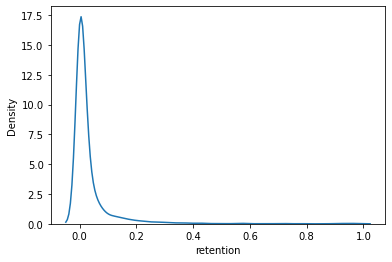

In [144]:
import seaborn as sns
sns.kdeplot(retention["retention"])

In [145]:
transactions.head()

,user_id,merchant_abn,dollar_value,order_id,order_datetime
0,1,28000487688,133.226894,0c37b3f7-c7f1-48cb-bcc7-0a58e76608ea,2021-02-28
1,18485,62191208634,79.131400,9e18b913-0465-4fd4-92fd-66d15e65d93c,2021-02-28
2,1,83690644458,30.441348,40a2ff69-ea34-4657-8429-df7ca957d6a1,2021-02-28
3,18488,39649557865,962.813341,f4c1a5ae-5b76-40d0-ae0f-cb9730ac325a,2021-02-28
4,2,80779820715,48.123977,cd09bdd6-f56d-489f-81ea-440f4bda933c,2021-02-28


Momemtum calculations are SMA(n) - SMA(n-1)

In [146]:

transactions["month"] = pd.DatetimeIndex(transactions['order_datetime']).year * 12 + pd.DatetimeIndex(transactions['order_datetime']).month
transaction_momentum = transactions.groupby(["merchant_abn", "month"]).agg(monthly_revenue=("dollar_value", sum)).reset_index()
transactions_groupby = transaction_momentum.groupby("merchant_abn")


In [147]:
sma_periods = [3, 5, 9]
col_names = [f"{sma_period}-month-sma" for sma_period in sma_periods]
diff_col_names = [f"{sma_period}-month-sma-diff" for sma_period in sma_periods]




for i, sma_period in enumerate(sma_periods):
    transaction_momentum[col_names[i]] = transactions_groupby.rolling(window=sma_period, on="month").mean().reset_index(drop=True).fillna(0)["monthly_revenue"]

transaction_momentum[diff_col_names] = transaction_momentum.sort_values(["merchant_abn", "month"]).groupby("merchant_abn").diff().fillna(0)[col_names]

transaction_momentum[transaction_momentum["merchant_abn"] == 64403598239]

,merchant_abn,month,monthly_revenue,3-month-sma,5-month-sma,9-month-sma,3-month-sma-diff,5-month-sma-diff,9-month-sma-diff
46098,64403598239,24254,10903.818738,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
46099,64403598239,24255,337930.374244,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
46100,64403598239,24256,353467.505688,234100.566223,0.000000,0.000000,234100.566223,0.000000,0.000000
46101,64403598239,24257,386881.564074,359426.481335,0.000000,0.000000,125325.915112,0.000000,0.000000
46102,64403598239,24258,391124.841648,377157.970470,296061.620878,0.000000,17731.489135,296061.620878,0.000000
46103,64403598239,24259,401233.794359,393080.066693,374127.616003,0.000000,15922.096224,78065.995124,0.000000
46104,64403598239,24260,432186.111239,408181.582415,392978.763402,0.000000,15101.515722,18851.147399,0.000000
46105,64403598239,24261,418335.511447,417251.805682,405952.364553,0.000000,9070.223266,12973.601152,0.000000
46106,64403598239,24262,465534.996956,438685.539881,421683.051130,355288.724266,21433.734199,15730.686576,355288.724266
46107,64403598239,24263,601243.679071,495038.062491,463706.818615,420882.042081,56352.522611,42023.767485,65593.317815


In [148]:
revenue_and_momentum = transaction_momentum.groupby("merchant_abn").last().reset_index()

Next up, a transaction volume/total revenue model. We assume that the distribution of transaction amount remains relatively constant over time for each merchant for this model.

In [149]:

counts = transactions.groupby(["merchant_abn", "order_datetime"]).agg(count=("dollar_value", "count")).reset_index().groupby("merchant_abn").agg(volume_mean=("count", "mean"), volume_stdev=("count", "std"))
counts = pd.concat([counts, transactions.groupby(["merchant_abn"]).agg(amount_mean=("dollar_value", "mean"), amount_stdev=("dollar_value", "std"))], axis=1).reset_index()
counts

,merchant_abn,volume_mean,volume_stdev,amount_mean,amount_stdev
0,10023283211,5.180464,2.456024,203.657831,118.637303
1,10142254217,4.813758,2.403893,33.229607,28.085452
2,10165489824,1.000000,0.000000,15696.993910,4852.596967
3,10187291046,1.344398,0.672108,108.319194,66.611526
4,10192359162,1.328244,0.605755,403.599144,265.419403
...,...,...,...,...,...
4013,99938978285,27.140264,7.866560,25.260246,21.232901
4014,99974311662,1.125000,0.382618,272.166216,179.558785
4015,99976658299,36.765677,9.888195,142.225226,74.766046
4016,99987905597,1.226027,0.508826,326.649998,152.671000


Here's what we've got to rank people now. The coefficients were somewhat arbitrarily decided such that they had a sufficient effect on the ranking, they should be tuned. We need to introduce some more features as well.

In [151]:
ranking = retention.reset_index().merge(counts).merge(revenue_and_momentum).fillna(0)
ranking["score"] = ranking["9-month-sma"].multiply(ranking["take_rate"].astype(float))/100 + 0.5 * (ranking["9-month-sma-diff"] + ranking["5-month-sma-diff"] + ranking["3-month-sma-diff"]) + 50 * (ranking["volume_mean"] - ranking["volume_stdev"]) + ranking["retention"] * 10000
ranking.sort_values("score", ascending=False)

,index,merchant_abn,name,tags,sector_tags,revenue_band,take_rate,retention,volume_mean,volume_stdev,...,amount_stdev,month,monthly_revenue,3-month-sma,5-month-sma,9-month-sma,3-month-sma-diff,5-month-sma-diff,9-month-sma-diff,score
6,3590,89726005175,Est Nunc Consulting,"((tent and awning shops), (a), (take rate: 6.01))",tent and awning shops,a,6.01,0.937128,344.471947,74.531141,...,20.608227,24274,435949.318202,463494.049982,455934.991370,422031.730329,-6422.822195,-507.412569,13348.488687,51441.557299
1,3443,86578477987,Leo In Consulting,"[[watch, clock, and jewelry repair shops], [a]...","watch, clock, and jewelry repair shops",a,6.43,0.968827,431.739274,92.014181,...,20.367011,24274,433862.992375,473547.410634,470411.675053,436292.492109,-13759.648929,-4211.533852,11235.478199,51360.277826
3,1827,49891706470,Non Vestibulum Industries,"((teNt and awning shops), (a), (take rate: 5.80))",tent and awning shops,a,5.80,0.959332,405.019802,87.756950,...,15.015080,24274,376046.080007,398484.584074,396057.821167,366497.592915,-9224.868348,-2183.430435,11646.908020,46832.632007
12,2446,64403598239,Lobortis Ultrices Company,"((music shops - musical instruments, pianos, a...","music shops - musical instruments, pianos, and...",a,6.31,0.772384,185.437294,40.504405,...,41.599800,24274,462565.051837,493359.359024,485017.190924,449004.555040,-7900.575670,-424.535538,13140.936206,45710.589088
5,1637,45629217853,Lacus Consulting,"[[gift, Card, novelty, and souvenir shops], [a...","gift, card, novelty, and souvenir shops",a,6.98,0.940919,355.410891,79.046703,...,26.228252,24274,346208.729682,374073.260283,370908.771333,344292.906828,-10212.380807,-3210.177626,9969.036876,45532.280949
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1068,2202,58729395250,Aliquam LLC,"([hobby, toy and game shops], [b], [take rate:...","hobby, toy and game shops",b,4.78,0.023001,3.158261,1.698841,...,804.829031,24274,85383.623808,111495.226765,120070.954357,116888.979424,-22992.089654,-6242.443411,-2377.061352,-9915.525225
3268,1527,43083074133,Faucibus Leo In LLC,"([jewelry, watch, clock, and silverware shops]...","jewelry, watch, clock, and silverware shops",c,2.24,0.000000,1.073684,0.262642,...,4699.109071,24274,22232.423531,34681.569346,40530.195918,35925.410782,-16732.599724,-6979.100441,49.275644,-10985.930962
3882,2196,58495294020,Diam Nunc Associates,"((jewelry, watch, clock, and silverware shops)...","jewelry, watch, clock, and silverware shops",b,3.98,0.000000,1.000000,0.000000,...,6592.375924,24274,8792.961322,27518.640946,33305.911212,37430.073222,-15012.235332,-9555.146585,-781.834990,-11134.891539
3351,1553,43698886228,Nec Quam Corp.,"[(antique shops - sales, repairs, and restorat...","antique shops - sales, repairs, and restoratio...",c,3.08,0.000000,1.178571,0.402651,...,4275.565809,24274,9405.409867,34375.004684,36397.369080,33711.020419,-13260.041336,-5480.000601,-9664.929635,-13125.390312


In [17]:
merchant_groupings = {
    "tent and awning shops": "Miscellaneous Stores",
    "gift, card, novelty, and souvenir shops": "Miscellaneous Stores",
    "digital goods: books, movies, music": "Miscellaneous Stores",
    "watch, clock, and jewelry repair shops": "Miscellaneous Stores",
    "cable, satellite, and other pay television and radio services": "Utility services",
    "florists supplies, nursery stock, and flowers": "Retail outlet services",
    "opticians, optical goods, and eyeglasses": "Professional services and membership organisations",
    "computers, computer peripheral equipment, and software": "Retail outlet services",
    "computer programming , data processing, and integrated systems design services": "Business Services",
    "furniture, home furnishings and equipment shops, and manufacturers, except appliances": "Miscellaneous Stores",
    "artist supply and craft shops": "Miscellaneous Stores",
    "shoe shops": "Retail outlet services",
    "books, periodicals, and newspapers": "Retail outlet services",
    "lawn and garden supply outlets, including nurseries": "Retail outlet services",
    "music shops - musical instruments, pianos, and sheet music": "Miscellaneous Stores",
    "motor vehicle supplies and new parts": "Retail outlet services",
    "health and beauty spas": "Miscellaneous Stores",
    "hobby, toy and game shops": "Miscellaneous Stores",
    "bicycle shops - sales and service": "Miscellaneous Stores",
    "antique shops - sales, repairs, and restoration services": "Miscellaneous Stores",
    "stationery, office supplies and printing and writing paper": "Retail outlet services",
    "equipment, tool, furniture, and appliance rent al and leasing": "Business Services",
    "telecom": "Utility services",
    "art dealers and galleries": "Miscellaneous Stores",
    "jewelry, watch, clock, and silverware shops": "Miscellaneous Stores"
}

In [29]:
for grouping in set(merchant_groupings.values()):
    print(grouping)
    tags_list = [i for i in merchant_groupings.keys() if merchant_groupings[i] == grouping]
    display(ranking[ranking["sector_tags"].isin(tags_list)].sort_values("score", ascending=False).head())
    

Miscellaneous Stores


,merchant_abn,total_transactions,repeat_transactions,repeat_percent,name,sector_tags,revenue_band,take_rate,volume_mean,volume_stdev,...,amount_stdev,month,monthly_revenue,3-month-sma,5-month-sma,9-month-sma,3-month-sma-diff,5-month-sma-diff,9-month-sma-diff,score
3,89726005175,210531,210498,0.999843,Est Nunc Consulting,tent and awning shops,a,6.01,347.410891,76.271467,...,20.611374,24274,439892.053653,467700.104590,460120.264195,425714.419969,-6526.344029,-645.259662,13551.040188,52330.558629
0,86578477987,263923,263918,0.999981,Leo In Consulting,"watch, clock, and jewelry repair shops",a,6.43,435.516502,94.246848,...,20.378793,24274,438301.521566,478310.148950,475046.843647,440216.770192,-13855.996691,-4136.720865,11471.184061,52108.464819
6,64403598239,113541,112518,0.990990,Lobortis Ultrices Company,"music shops - musical instruments, pianos, and...",a,6.31,187.361386,41.652991,...,41.592244,24274,467609.334319,499344.096173,490517.461192,453936.232619,-7471.985241,-350.879275,13457.881764,48656.205045
1,49891706470,247526,247520,0.999976,Non Vestibulum Industries,tent and awning shops,a,5.80,408.458746,89.701327,...,15.014905,24274,379946.375635,402341.846799,399610.869597,369534.849433,-8903.081737,-2067.526396,11877.525341,47824.108421
2,45629217853,217201,217169,0.999853,Lacus Consulting,"gift, card, novelty, and souvenir shops",a,6.98,358.417492,80.811948,...,26.236206,24274,349534.308410,378319.589181,374868.025189,347484.892785,-10272.350197,-3208.364019,10144.666556,46465.225606


Retail outlet services


,merchant_abn,total_transactions,repeat_transactions,repeat_percent,name,sector_tags,revenue_band,take_rate,volume_mean,volume_stdev,...,amount_stdev,month,monthly_revenue,3-month-sma,5-month-sma,9-month-sma,3-month-sma-diff,5-month-sma-diff,9-month-sma-diff,score
1844,31385641294,3647,504,0.138196,Semper Auctor PC,motor vehicle supplies and new parts,b,4.52,6.048093,2.647510,...,1387.838027,24274,435738.016535,420947.680403,407993.679251,375871.777030,16679.306970,9536.768997,22936.646806,43117.752607
1602,43186523025,195802,195746,0.999714,Lorem Ipsum Sodales Industries,"florists supplies, nursery stock, and flowers",b,4.47,323.105611,71.686084,...,22.383047,24274,437650.070510,470616.988934,467049.118714,430507.050974,-11520.324572,-2199.053676,11993.860689,40949.022704
2954,24852446429,280387,280382,0.999982,Erat Vitae LLP,"florists supplies, nursery stock, and flowers",c,2.94,462.684818,100.265753,...,17.442418,24274,406943.855803,437759.856940,432608.999583,400672.865062,-9718.359517,-2323.319194,10826.374423,39292.905055
2957,68216911708,174165,174048,0.999328,Placerat Eget Venenatis Limited,"computers, computer peripheral equipment, and ...",c,3.05,287.400990,62.823451,...,24.749836,24274,310672.183639,336790.707235,335834.835094,310928.117936,-10225.404088,-2461.589177,8309.464187,28516.702224
68,45433476494,15854,7779,0.490665,Adipiscing Elit Foundation,"computers, computer peripheral equipment, and ...",a,5.82,26.161716,7.963362,...,200.389462,24274,365600.736163,412570.353564,400910.608635,369116.048826,-7648.249815,-2946.084558,11710.303038,27857.104271


Professional services and membership organisations


,merchant_abn,total_transactions,repeat_transactions,repeat_percent,name,sector_tags,revenue_band,take_rate,volume_mean,volume_stdev,...,amount_stdev,month,monthly_revenue,3-month-sma,5-month-sma,9-month-sma,3-month-sma-diff,5-month-sma-diff,9-month-sma-diff,score
11,48534649627,63217,58609,0.927108,Dignissim Maecenas Foundation,"opticians, optical goods, and eyeglasses",a,6.64,104.318482,24.149244,...,100.681253,24274,403562.038522,426877.790169,419614.235016,386808.630532,-7139.533464,1046.605211,11985.821665,41910.083792
2955,46804135891,223084,223066,0.999919,Suspendisse Dui Corporation,"opticians, optical goods, and eyeglasses",c,2.93,368.125413,80.942245,...,21.397731,24274,292892.156616,317675.687688,314675.291865,291493.576020,-9476.652508,-1716.500331,7638.184017,31121.628863
101,95574756848,11162,4223,0.378337,At Pede Inc.,"opticians, optical goods, and eyeglasses",a,6.15,18.419142,5.622202,...,195.147832,24274,189922.763713,206035.081931,202190.620987,189808.811028,-4874.292333,-1529.434808,4035.420839,14912.307886
2976,11237511112,19899,11094,0.557515,Magna Institute,"opticians, optical goods, and eyeglasses",c,2.11,32.836634,8.868071,...,137.132309,24274,202445.596073,219168.526012,214362.284876,199014.335270,-1089.089925,-1143.094109,6442.933168,13078.159689
2960,11566786699,42471,35189,0.828542,Euismod Et Institute,"opticians, optical goods, and eyeglasses",c,2.62,70.084158,17.615297,...,21.514090,24274,57539.750066,62032.924255,61727.128216,56389.639146,-1137.892344,-60.065249,1692.429791,12633.505998


Business Services


,merchant_abn,total_transactions,repeat_transactions,repeat_percent,name,sector_tags,revenue_band,take_rate,volume_mean,volume_stdev,...,amount_stdev,month,monthly_revenue,3-month-sma,5-month-sma,9-month-sma,3-month-sma-diff,5-month-sma-diff,9-month-sma-diff,score
1614,35909341340,36902,28834,0.781367,Arcu Sed Eu Incorporated,"computer programming , data processing, and in...",b,4.80,60.894389,15.376339,...,133.831536,24274,457520.959513,490193.834522,483058.849538,446692.689307,-14642.912433,-3014.299833,12907.434581,29155.931398
1626,77590625261,24570,15699,0.638950,Sed Diam Foundation,"computer programming , data processing, and in...",b,3.24,40.544554,11.013463,...,149.730145,24274,384886.516384,403928.092249,389043.716913,364989.991075,3035.076849,-2241.378816,13489.985365,26833.571392
22,67400260923,36173,28041,0.775191,Eleifend PC,"computer programming , data processing, and in...",a,5.97,59.691419,15.376772,...,95.800098,24274,254250.966165,268396.329881,269162.256111,249103.905474,-7596.484664,1129.829470,6838.802974,25025.223816
37,58454491168,25860,16980,0.656613,Diam At Foundation,"computer programming , data processing, and in...",a,6.01,42.673267,10.793272,...,133.844769,24274,296877.871203,336949.202800,333649.943785,313384.557500,-11780.271899,-5472.733040,6925.888378,21830.978677
2962,84703983173,40428,33050,0.817503,Amet Consulting,"computer programming , data processing, and in...",c,2.31,66.712871,16.058984,...,71.787662,24274,182598.650941,197673.333833,196850.074430,180302.607288,-5358.963933,1138.100164,5018.948625,15271.754218


Utility services


,merchant_abn,total_transactions,repeat_transactions,repeat_percent,name,sector_tags,revenue_band,take_rate,volume_mean,volume_stdev,...,amount_stdev,month,monthly_revenue,3-month-sma,5-month-sma,9-month-sma,3-month-sma-diff,5-month-sma-diff,9-month-sma-diff,score
5,21439773999,116938,116059,0.992483,Mauris Non Institute,"cable, satellite, and other pay television and...",a,6.10,192.966997,43.475030,...,45.536326,24274,449627.223633,474262.158965,471611.447193,436286.846671,-8806.035751,-13.410568,13809.394678,46507.902115
218,82368304209,4985,968,0.194183,Nec Incorporated,telecom,a,5.55,8.226073,3.286845,...,1194.263054,24274,479386.758960,484073.281164,467162.006218,435409.397010,3413.320095,115.096546,15676.327560,35956.380475
1924,93260930990,2355,206,0.087473,Pede Cras Vulputate Ltd,telecom,b,3.15,3.957983,2.096955,...,1936.743395,24274,426530.221943,481236.311935,461524.816209,424173.298859,-1324.944146,3339.286726,6680.160989,18676.496700
24,17488304283,32985,24525,0.743520,Posuere Cubilia Curae Corporation,"cable, satellite, and other pay television and...",a,6.18,54.430693,13.861928,...,52.984879,24274,158509.261145,170701.566751,170283.126237,157528.351392,-5371.339514,-1483.017468,4437.432715,17990.426068
25,29521780474,31759,23340,0.734910,At Sem Corp.,"cable, satellite, and other pay television and...",a,5.93,52.407591,13.471631,...,28.071028,24274,53970.491859,58420.098670,58156.911769,54184.575892,-1351.019407,-388.503681,1482.995356,12380.777379


Now for ranking within groupings

In [14]:
ranking.dtypes

total_transactions       int64
repeat_transactions      int64
repeat_percent         float64
name                    object
merchant_abn             int64
sector_tags             object
revenue_band            object
take_rate               object
volume_mean            float64
volume_stdev           float64
amount_mean            float64
amount_stdev           float64
month                    int64
monthly_revenue        float64
3-month-sma            float64
5-month-sma            float64
9-month-sma            float64
3-month-sma-diff       float64
5-month-sma-diff       float64
9-month-sma-diff       float64
score                  float64
dtype: object

In [15]:
transactions["month"] = pd.DatetimeIndex(transactions['order_datetime']).year * 12 + pd.DatetimeIndex(transactions['order_datetime']).month/3

transactions["quarter"] = transactions["month"].apply(math.ceil)


df = transactions.merge(consumers, on="user_id").drop(["month", "consumer_id", "user_id"], axis=1).groupby(["postcode", "quarter", "merchant_abn"]).sum().reset_index()

In [16]:
transactions.head()

,user_id,merchant_abn,dollar_value,order_id,order_datetime,month,quarter
index,,,,,,,
0,1,28000487688,133.226894,0c37b3f7-c7f1-48cb-bcc7-0a58e76608ea,2021-02-28,24252.666667,24253
1,18485,62191208634,79.131400,9e18b913-0465-4fd4-92fd-66d15e65d93c,2021-02-28,24252.666667,24253
2,1,83690644458,30.441348,40a2ff69-ea34-4657-8429-df7ca957d6a1,2021-02-28,24252.666667,24253
3,18488,39649557865,962.813341,f4c1a5ae-5b76-40d0-ae0f-cb9730ac325a,2021-02-28,24252.666667,24253
4,2,80779820715,48.123977,cd09bdd6-f56d-489f-81ea-440f4bda933c,2021-02-28,24252.666667,24253


In [17]:
df.count()


postcode        7686159
quarter         7686159
merchant_abn    7686159
dollar_value    7686159
dtype: int64

In [18]:
# census_consumers["yr 12 completion"] = census_consumers[["gender", "comp_Yr_12_eq_percent_M", "comp_Yr_12_eq_percent_F"]].apply(lambda x: x["comp_Yr_12_eq_percent_" + ("M", "F")[["gender"] == "Female"]], axis=1)

In [19]:
len(df)

7686159

My sad attempts at trying to fix the model below

In [20]:




# def train(df, census_consumers, merchants):
#     ENCODED_COLS = ["gender", "sector_tags", "revenue_band"]
#     SCALED_COLS = ["yr 12 completion", "house_repay_to_income", "Median_age_persons", "Median_tot_prsnl_inc_weekly", "Median_mortgage_repay_monthly", "take_rate"]
#     model = SGDRegressor()
#     encoder = OneHotEncoder()
#     scaler = StandardScaler()
#     i = 0
#     df = df.sample(frac=1)
#     interval = int(1e5)
#     test_size = int(1e5)
#     while i < len(df):
#         print(f"Training Sample: {i}-{min(i+interval, len(df)-test_size)}")
#         df_merged = df[i:min(i+interval, len(df)-test_size)].merge(census_consumers, on=["postcode"]).merge(merchants, on=["merchant_abn"]).replace([np.inf, -np.inf], np.nan).dropna()
#         i += interval
#         X, y = get_features_and_labels(df_merged, encoder, scaler, ENCODED_COLS, SCALED_COLS)
#         model.partial_fit(X, y)
#     test_df = df[-test_size:].merge(census_consumers, on=["postcode"]).merge(merchants, on=["merchant_abn"]).replace([np.inf, -np.inf], np.nan).dropna()
#     print(f"Test Score: {model.score(*get_features_and_labels(test_df, encoder, scaler, ENCODED_COLS, SCALED_COLS, train=False))}")

# def get_features_and_labels(df, encoder, scaler, ENCODED_COLS, SCALED_COLS, train=True):
#         X = df[["gender", "yr 12 completion", "house_repay_to_income", "Median_age_persons", "Median_tot_prsnl_inc_weekly", "Median_mortgage_repay_monthly", "sector_tags", "revenue_band", "take_rate"]]
#         X["take_rate"] = pd.to_numeric(X["take_rate"])
#         X["house_repay_to_income"] = pd.to_numeric(X["house_repay_to_income"])
#         scaled_columns =  scaler.fit_transform(X[SCALED_COLS]) if train else scaler.transform(X[SCALED_COLS])
#         encoded_columns =  encoder.fit_transform(X[ENCODED_COLS]) if train else encoder.transform(X[ENCODED_COLS])
#         X = np.concatenate([scaled_columns, encoded_columns], axis=1)
#         y = df["dollar_value"]
#         return X, y





In [21]:
# train(df, census_consumers, merchants)

In [22]:
df_merged.count()

NameError: name 'df_merged' is not defined

22/10/06 02:02:19 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/10/06 02:02:19 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/10/06 02:02:19 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/10/06 02:02:19 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/10/06 02:02:19 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/10/06 02:02:19 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/10/06 0

In [ ]:
# len(X)

22/10/06 02:03:44 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/10/06 02:03:44 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/10/06 02:03:45 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/10/06 02:03:45 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/10/06 02:03:45 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/10/06 02:03:45 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/10/06 0

819047

22/10/06 02:04:11 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/10/06 02:04:11 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/10/06 02:04:11 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/10/06 02:04:11 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/10/06 02:04:11 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/10/06 02:04:11 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/10/06 0

In [ ]:
# X = X.to_pandas()

22/10/06 02:05:07 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/10/06 02:05:07 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/10/06 02:05:07 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/10/06 02:05:07 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/10/06 02:05:07 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
22/10/06 02:05:07 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradat

In [ ]:
# y = y.to_pandas()

NameError: name 'y' is not defined

In [ ]:
# type(X)

pyspark.pandas.frame.DataFrame

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

22/10/06 01:53:58 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/10/06 01:53:58 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/10/06 01:53:58 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/10/06 01:53:58 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/10/06 01:53:58 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/10/06 01:53:58 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/10/06 0

KeyboardInterrupt: 

In [ ]:
# model = ElasticNet()
# model.fit(X_train, y_train)

ElasticNet()

In [ ]:
# model.score(X_test, y_test)

0.010071754222644724